## Import Libraries

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import glob

import pickle

In [2]:
with open("Transfer-Learning.pickle",'wb') as f:
    pickle.dump("Transfer-Learning", f)

with  open("Transfer-Learning.pickle", "rb") as f:
     pickle.load(f)



The goal of the project is to detect pneumonia disease from a person lung image using deep learning convolutional neural network. Chest-x-ray image dataset downloaded from Kaggle competition website. The steps of the implementation are as follows


### Define the path for dataset directories

In [3]:
DATADIR = ".\chest_xray\chest_xray"

In [4]:
# Collect the data from each directory
train_dir = os.path.join(DATADIR, 'train')
val_dir = os.path.join(DATADIR, 'val')
test_dir = os.path.join(DATADIR, 'test')

In [5]:
train_dir

'.\\chest_xray\\chest_xray\\train'

In [6]:
# Use glob function to add images classes
pneumonia_images = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_images = glob.glob(train_dir+"/NORMAL/*.jpeg")


### Visualization of the sample images of pneumonia infected versus normal lung

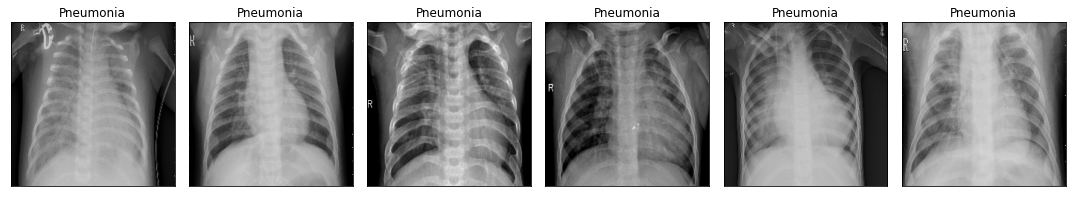

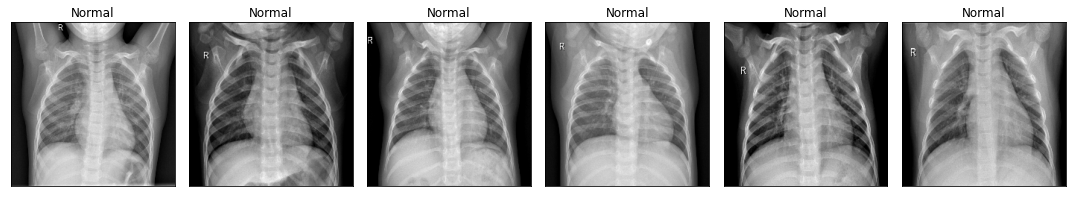

In [7]:

fig, axes = plt.subplots(nrows=1, ncols=6,
                         figsize=(15,10), 
                         subplot_kw={'xticks':[],
                                     'yticks':[]})

for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_images[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    
    ax.set_title("Pneumonia")
fig.tight_layout()   
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), 
                         subplot_kw={'xticks':[],
                                     'yticks':[]})

for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_images[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    
plt.show()

## Create Image Generator

We have rescaled the images by dividing the pixel values by 255
To maintain uniform size of the image, we have also configured the images to shape (220, 220)

In [8]:
train_gen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_gen = ImageDataGenerator(rescale = 1./255.,)
test_gen = ImageDataGenerator(rescale = 1./255.,)


train_ds = train_gen.flow_from_directory(train_dir, 
                                         batch_size=32, 
                                         class_mode='binary', target_size = (220, 220))
val_ds = val_gen.flow_from_directory(val_dir,
                                     batch_size=8, 
                                     class_mode = 'binary', 
                                     target_size=(220, 220))
test_ds = test_gen.flow_from_directory(test_dir,
                                       shuffle=False, 
                                       batch_size=16, 
                                       class_mode = 'binary', 
                                       target_size=(220, 220))

Found 5215 images belonging to 2 classes.
Found 114 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


There is a data imbalance between the training versus the test dataset that might lead to model overfitting. To minimize the overfitting, I  applied the data augmentation technique to multiply the images artificially using the flip horizontally and random rotate technique.

In [9]:
# Data augumentation to propagate the number of data from the existing dataset using Random flip and rotation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


Define Input Shape to Convolutional neural network for Transfer Learning 

In [10]:
# Input shape
input_shape = (220, 220, 3)


## Create the Model 

In [11]:
# Create the base model from the pre-trained model ResNet50V2
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)


### Freez the top layers

In [12]:
# Freez-the top layers
for layer in base_model.layers:
    layer.trainable = False
    

### Define the model for transfer learning

In [13]:
# Define the model for transfer learning
# Transfer Learning
# This would fix the weights of the layers of the base model

# Only one additional layer added on top of the base layer will be trained

model = Sequential()
model.add(data_augmentation)
model.add(base_model)
model.add(GlobalAveragePooling2D())
#model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))



In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 226, 226, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 110, 110, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 112, 112, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [15]:
# the value of tran_ds is a generator and the values from it will generated from next() method

images_batch, labels_batch = next(iter(train_ds))

In [16]:
# Compile the model, the main parameters are defiend in the during the compile process

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

C:\Users\me\Documents\CONDA_2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


#### Use Early Stopping  when parameter stop to show improvment over a certain number of epochs to curb computation time.

In [17]:
# Apply Early stopping if the accuracy declined above certain number of epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

## Train the Model

In [18]:
# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    steps_per_epoch = 60, 
                    epochs=20,
                    callbacks=callback)

Epoch 1/20


C:\Users\me\Documents\CONDA_2\lib\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


60/60 [==============================] - 316s 5s/step - loss: 0.9174 - accuracy: 0.4388 - val_loss: 0.7115 - val_accuracy: 0.5965
Epoch 2/20
60/60 [==============================] - 219s 4s/step - loss: 0.6603 - accuracy: 0.6969 - val_loss: 0.6814 - val_accuracy: 0.5965
Epoch 3/20
60/60 [==============================] - 220s 4s/step - loss: 0.5795 - accuracy: 0.7271 - val_loss: 0.5809 - val_accuracy: 0.6404
Epoch 4/20
60/60 [==============================] - 2085s 35s/step - loss: 0.5462 - accuracy: 0.7417 - val_loss: 0.5081 - val_accuracy: 0.7456
Epoch 5/20
60/60 [==============================] - 239s 4s/step - loss: 0.5197 - accuracy: 0.7505 - val_loss: 0.4489 - val_accuracy: 0.7719
Epoch 6/20
60/60 [==============================] - 239s 4s/step - loss: 0.4583 - accuracy: 0.7848 - val_loss: 0.4028 - val_accuracy: 0.7895
Epoch 7/20
60/60 [==============================] - 237s 4s/step - loss: 0.4322 - accuracy: 0.7958 - val_loss: 0.3798 - val_accuracy: 0.8070
Epoch 8/20
60/60 [====

In [19]:
# Save the mode
model.save("model1")

C:\Users\me\Documents\CONDA_2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model1\assets


In [20]:
model.evaluate(test_ds)

39/39 [==============================] - 67s 2s/step - loss: 0.4028 - accuracy: 0.7837


[0.40278360247612, 0.7836538553237915]

In [21]:
# Model performance metrics
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


### Visualize the training and validation data accuracies and losses¶


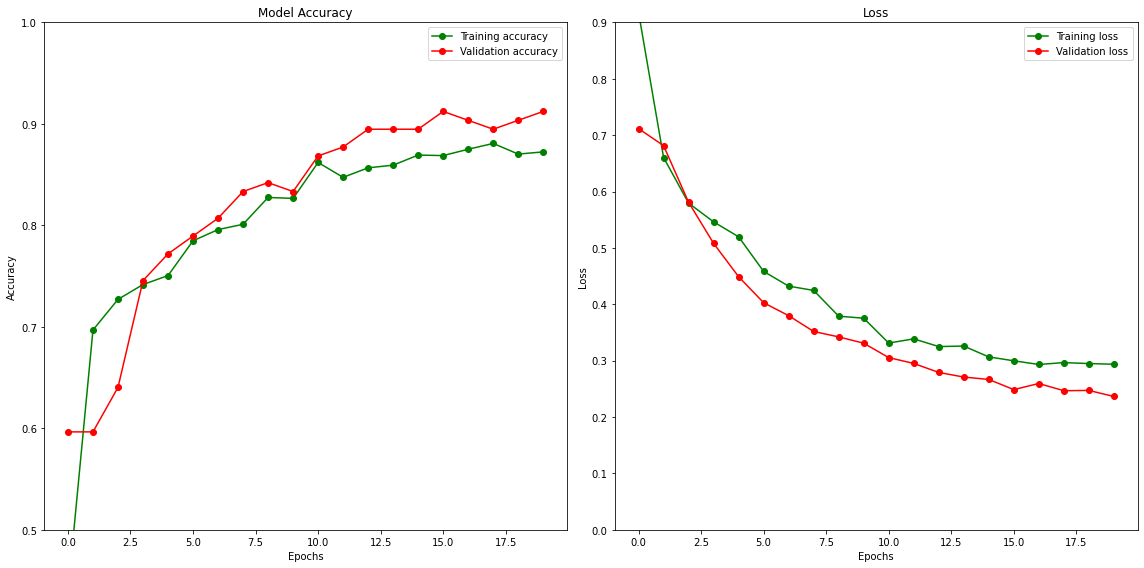

In [22]:
# Visualization
plt.figure(figsize=(16,8))
epochs = [i for i in range(20)]
#plt.figure(figsize=(15,10))
#fig, ax = plt.subplots(1,2)
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'go-', label = "Training accuracy")
plt.plot(epochs, val_accuracy,'ro-', label="Validation accuracy")
plt.ylim(0.5, 1)
plt.legend()
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'g-o', label = "Training loss")
plt.plot(epochs, val_loss, 'r-o', label="Validation loss")
plt.ylim(0, 0.9)
plt.legend()
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.tight_layout()          
plt.show()


### Predict the model 

In [23]:
# Predict the test dataset
pred = model.predict(test_ds)

In [24]:
# classifciy the probability result into 1 or 0
predicted = []
for prob in pred:
    if prob >= 0.5:
        predicted.append(1)
    else:
        predicted.append(0)

In [25]:
# Assign the y_true or the test dataset classes that is either Pneumonia 
# or Normal
y_true = test_ds.classes

In [26]:
# Total number of test datapoint
len(y_true)

624

In [27]:
# The number of pnuemonia datapoints
print( f"The size of pnuemonia datapoint is: {sum(y_true)}, and the proportion is:  {sum(y_true)/len(y_true)}")

The size of pnuemonia datapoint is: 390, and the proportion is:  0.625


### Confusion Matrix

In [28]:
# confusion matrix return TN, TP, FP,FN
cm = confusion_matrix(y_true, predicted)


In [29]:
cm

array([[116, 118],
       [ 17, 373]], dtype=int64)

<AxesSubplot:>

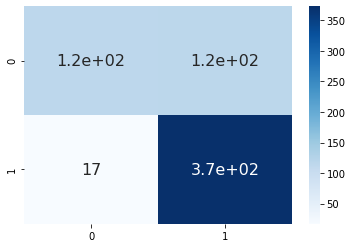

In [30]:
# Heat map using seeborn
sn.heatmap(cm, annot=True,cmap="Blues", annot_kws={"size": 16})

In [31]:
print(classification_report(y_true, predicted))

              precision    recall  f1-score   support

           0       0.87      0.50      0.63       234
           1       0.76      0.96      0.85       390

    accuracy                           0.78       624
   macro avg       0.82      0.73      0.74       624
weighted avg       0.80      0.78      0.77       624



Modeling should return a better outcome on Recall as  recall is the most important parameter in particular to a health case prediction. Recall or
Sensitivity explains how much of the actual true Postive is predicted as true positive.

In [32]:
#### The dimensions of our input image
img_width = 220
img_height = 220

# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
#layer_name = ['conv2_block1-conv', 'conv2_block2_1_conv', 'conv2_block_3_1_conv',
              #'conv3_block4_1_conv',"conv5_block3_3_conv"]
layer_name = 'conv5_block3_3_conv'


### Build a ResNet50V2 model loaded with pre-trained ImageNet weights

In [33]:
# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False)

#for layer in model.layers:
    #if layer in layer_name:
        # Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)

feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)


#### Define compute loss function

In [34]:
def compute_loss(images_batch, filter_index):
    activation = feature_extractor(images_batch)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)



In [35]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [36]:

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [37]:
from IPython.display import Image, display
import numpy as np
loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("0.jpg", img)

#### Visualize the first filter image from last convolutional layer

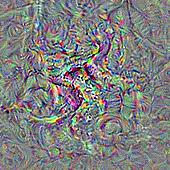

In [38]:
display(Image("0.jpg"))

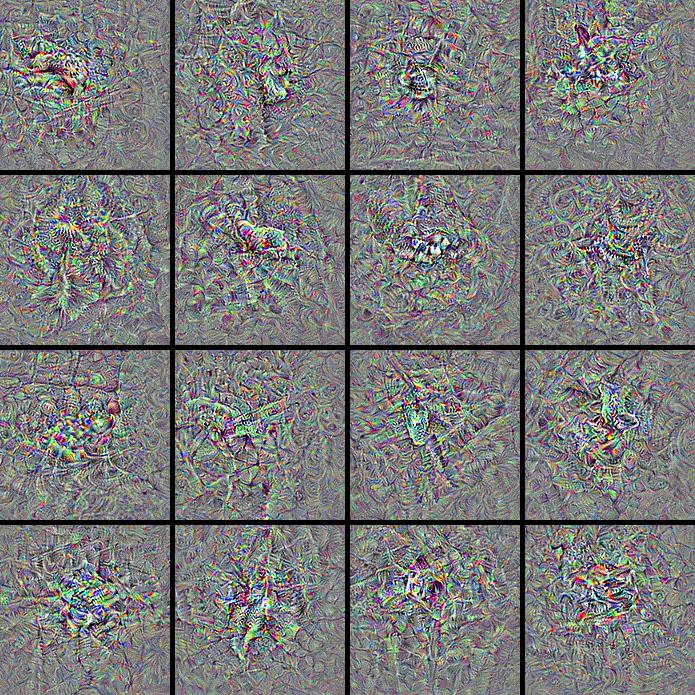

In [39]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(36):
   # print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 4
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.jpg", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.jpg"), layer)


## ROC Curve

In [40]:
from sklearn.metrics import roc_curve
# roc curve for models
fpr, tpr , thresh1 = roc_curve(y_true, pred, pos_label = 1)
 # roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_true))]
p_fpr, p_tpr , _  = roc_curve(y_true, random_probs, pos_label=1)

In [41]:
from sklearn.metrics import roc_auc_score
# auc scores
auc_score = roc_auc_score(y_true, pred)
auc_score = round(auc_score,2)
auc_score

0.93

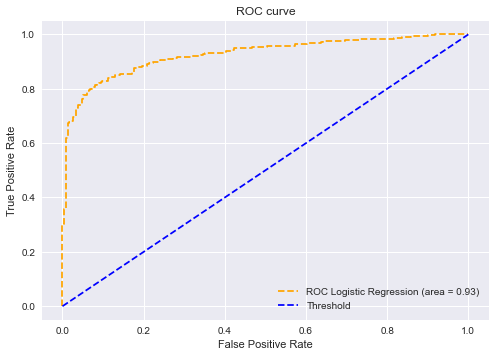

In [42]:
import  matplotlib.pyplot as plt
plt.style.use('seaborn')
# plot roc curves
plt.plot(fpr,tpr, linestyle='--', color='orange', label='ROC Logistic Regression (area = '+str(auc_score)+')')
plt.plot(p_fpr, p_tpr, linestyle= "--", color = 'blue', label = 'Threshold')
# title
plt.title('ROC curve')
# x label
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.legend(loc = 'best')
plt.savefig('ROC curve', dpi=300)
plt.show()

### AUC Score

In [43]:
from sklearn.metrics import roc_auc_score
# auc scores
auc_score = roc_auc_score(y_true, pred)
auc_score = round(auc_score,2)
auc_score

0.93

In [44]:
precision, recall, thresholds = precision_recall_curve(y_true, pred)

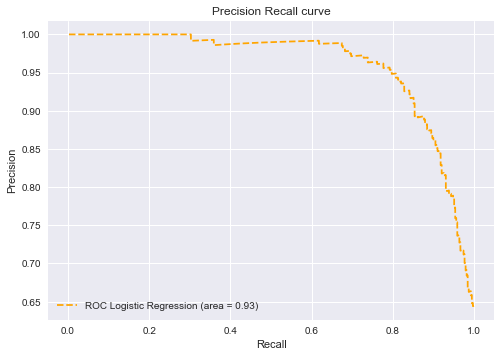

In [45]:
import  matplotlib.pyplot as plt
plt.style.use('seaborn')
# plot roc curves
plt.plot( recall, precision, linestyle='--', color='orange', label='ROC Logistic Regression (area = '+str(auc_score)+')')
#plt.plot(p_fpr, p_tpr, linestyle= "--", color = 'blue', label = 'Threshold')
# title
plt.title('Precision Recall curve')
# x label

plt.xlabel("Recall")
plt.ylabel('Precision')
plt.legend(loc = 'best')
plt.savefig('Precison Recall curve', dpi=300)
plt.show()

In [46]:
# optimal threshold
# I am interested to get less false negative and more True positive
#precision, recall,  thresholds = precision_recall_curve(y_true, pred)

### f1_score metric perform better to imbalance data

In [47]:
# f1_score harmonic mean of precision and recall, Beta = 2
# f1_score = (1 Beta**2)*(precision * recall)/(precision + recall)
beta = 3
f3_score = (1+ (beta**2))*(precision * recall) / (((beta**2) * precision) + recall)
len(f3_score)

601

In [48]:
# Optimal threshold from the threshold numpy array where tpr - fpr is the highest.
# get max index for the difference
threshold_indx = np.argmax(tpr-fpr)
# get the value from the tbresholds numpy array
optimal_threshold = thresholds[threshold_indx]
print('optimal_threshold: {:.3f} '.format(optimal_threshold))
print('F3_score: {:.3f}'.format(f3_score[threshold_indx]))


optimal_threshold: 0.252 
F3_score: 0.942


In [58]:
def plot_precision_recall_curve_threshold(y_true, pred):
    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(0,1, len(f3_score)), precision, color='blue', label ='Precision')
    plt.plot(np.linspace(0,1,len(f3_score)), recall, color = 'green', label='Recall')
    plt.plot([optimal_threshold, optimal_threshold],[0,1], color='gray')
    plt.plot([0.5, 0.5], [0, 1], color = 'gray')
    plt.plot(np.linspace(0,1,len(f3_score)), f3_score, color = 'red', label='recall')
    plt.annotate('Optimal_Threshold', xy=(optimal_threshold - 0.01, 0), xytext=(optimal_threshold -0.02,0.3), rotation =90, size=13)
    plt.annotate('Default_Threshold', xy=(0.5, 0), xytext=(0.48,0.3), rotation =90, size=13)
    plt.annotate('Optimal Recall', xy=(optimal_threshold, 0.95),xytext=(optimal_threshold + 0.1, 0.98), arrowprops=dict(facecolor='black'))
    plt.xlabel('Threshold')
    plt.ylabel('score')
    
    plt.title('Precision-Recall vs. Threshold', size='18')
    plt.legend()
    plt.show()


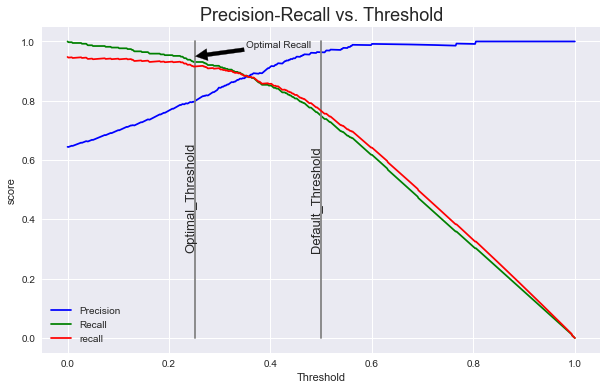

In [59]:
plot_precision_recall_curve_threshold(y_true, pred)


F-score is the best metric mainly when the data is not balanced, and it provides the opportunity to have optimal and default thresholds on which model performance evaluate,  in addition, it gives clients room to adjust the threshold to the desired outcome.


This project seeks the best score from recall regardless of the precision negative impact as the pneumonia is acute and time-sensitive for survival. I opt stringent threshold at  0.1 to maximize recall at the cost of precision, and it returns 99% recall.

In [60]:
# Using threshold equals t 0.1
new_predicted = []
for thresh in  pred:
    if thresh <= optimal_threshold:
        new_predicted.append(0)
    else:
        new_predicted.append(1)

In [61]:
# Confusion Matrix
cm = confusion_matrix(y_true, new_predicted)

In [62]:
# The matrix value
cm

array([[ 52, 182],
       [  6, 384]], dtype=int64)

<AxesSubplot:>

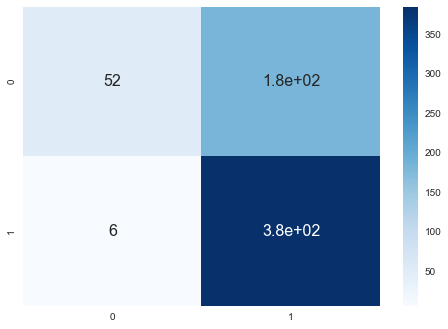

In [63]:
# Ploting confusion matrix 
sn.heatmap(cm, annot =True, cmap='Blues', annot_kws={"size":16})

In [64]:
# The metrics model performance 
print(classification_report(y_true, new_predicted))

              precision    recall  f1-score   support

           0       0.90      0.22      0.36       234
           1       0.68      0.98      0.80       390

    accuracy                           0.70       624
   macro avg       0.79      0.60      0.58       624
weighted avg       0.76      0.70      0.64       624



# Summary
From precision, recall, and threshold plot, the F score gives a clear guide to choose the threshold where the desired precision and recall result is satisfactory. The choice of the threshold is rely on
the business problem and the client decision